In [1]:
''' Code from Haodong Qin
edited by Iulia Rusu 
'''

import sys, os #, re, glob, socket, glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams




In [2]:
#import sci-kit learn for logistic regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

### 1: Functions needed for geodesic projection

In [3]:
def Mobius_addition(x,y,c):

    # x,y are N-dim vectors, c is the curvature of the hyperbolic space
    # vector addition in hyperbolic space

    top = (1 + 2*c* np.dot(x,y) + c* np.dot(y,y))*x + (1-c*np.dot(x,x))*y
    bottom = 1 + 2*c* np.dot(x,y) + c**2*np.dot(x,x)*np.dot(y,y)
    return top/bottom


def Mobius_scalarMulti(x,r,c):

    # scalar vector multiplication
    # x is a N-dim vector, c is the curvature of the hyperbolic space

    result = 1/np.sqrt(c)*np.tanh(r*np.arctanh(np.sqrt( c*np.dot(x,x) ))) * x/np.sqrt(np.dot(x,x))
    return result 


def Geodesic_distance(x,y,c):
    
    # x,y are N-dim vectors, c is the curvature of the hyperbolic space
    # vector addition in hyperbolic space
    direc_vector = Mobius_addition(-x,y,c)
    dist = 2/np.sqrt(c)*np.arctanh(np.sqrt(c * np.dot(direc_vector,direc_vector) ))

    return dist

def Geodesic_r(t,x,y,c):

    # find the position vector on the geodesic connecting two vectors x and y 
    # when t = 0, final_position = x
    # when t = 1, final_position = y
    direc_vector = Mobius_addition(-x,y,c)

    displace_vector = Mobius_scalarMulti(direc_vector,t,c)

    final_position = Mobius_addition(x,displace_vector,c)

    return final_position

def Geodesic_projection_OptFun(t,x,y,c,p):
    # Function that is needed to optimized to find the geometric projection t
    # x,y are N-dim vectors, c is the curvature of the hyperbolic space
    # geodesic is connecting x and y
    # p is some vector 

    r_geodesic = Geodesic_r(t,x,y,c)

    dist = Geodesic_distance(p,r_geodesic,c)

    return dist


def conformal_factor(x,c):
    # deformation of the mapping from linear to hyperbolic space at position x

    lambda_c_x = 2/(1-c*np.dot(x,x))
    return lambda_c_x

def logarithmic_map(x,y,c):

    # the logarithmic_map will map a position vector y onto the tangent space at x in a hyperbolic space with curvature c
    # logarithmic_map: position in hyperbolic space -> tangent vector in tangent space
    
    minus_x_plus_y = Mobius_addition(-x,y,c)

    length_minus_x_plus_y = np.sqrt(np.dot(minus_x_plus_y,minus_x_plus_y))

    prefactor = 2/np.sqrt(c)/conformal_factor(x,c)*np.arctanh(np.sqrt(c)*length_minus_x_plus_y) 

    tangent_vector = prefactor*minus_x_plus_y/length_minus_x_plus_y

    return tangent_vector

def exponential_map(x,v,c):

    # the exponential_map will map a tangent vector v in the tangent space at x to a position vector in hyperbolic space with curvature c
    # exponential_map: tangent vector in tangent space -> position in hyperbolic space

    # first mapping the tangent vector v in linear space to vector in hyperbolic space
    length_v = np.sqrt(np.dot(v,v))
    constant_1 = np.sqrt(c)*conformal_factor(x,c)*length_v/2
    v_hyp = np.tanh(constant_1)*v/length_v/np.sqrt(c)

    # position vector in hyperbolic space:
    position_vector = Mobius_addition(x,v_hyp,c)

    return position_vector


    

### 3: doing the geometric projection

In [4]:
def hyp_to_hyp_poincare(hyp):

    t = 1
    for coord_idx in hyp.columns:

        t = t + hyp[coord_idx]**2

    t = np.sqrt(t)

    hyp_geo = hyp.copy()

    for coord_idx in hyp_geo.columns:

        hyp_geo[coord_idx] =  hyp_geo[coord_idx]/(1+t)

    return hyp_geo


In [5]:
#access hyp_emb from different notebook
%store -r w0_ava_rme
%store -r w1_ava_rme
%store -r w2_ava_rme
%store -r w3_ava_rme
%store -r w4_ava_rme
%store -r w5_ava_rme
%store -r w6_ava_rme


In [6]:
#  import your data as dataframe, make sure the columns only include coordinates in the hyperbolic space
df_data = pd.DataFrame(np.concatenate([w0_ava_rme, w1_ava_rme, w2_ava_rme, w3_ava_rme, w4_ava_rme, w5_ava_rme, w6_ava_rme],axis = 0) )

# select the point where the tangent space is located, usually at the origin
reference_point_tangent_space =  np.zeros(df_data.shape[1])

In [7]:
df_data

,0,1,2
0,0.160495,-0.347612,-0.324184
1,0.149646,-0.342553,-0.329839
2,0.157287,-0.349319,-0.335812
3,0.166503,-0.356502,-0.323718
4,0.167412,-0.362113,-0.326391
...,...,...,...
77,-0.039181,-0.179207,0.561834
78,-0.125978,0.372208,0.494992
79,0.453220,0.113079,0.186094
80,0.536327,0.312181,0.062281


In [8]:
# transform the coordinates from native to Poincare ball
hyp_poincare = hyp_to_hyp_poincare(df_data)

# constant, this is fixed, no change
c_hyperbolicSpace = 1

# calculate the tangent vector using logrithmic map
hyp_tangent = hyp_poincare.copy()

for i in range(hyp_poincare.shape[0]):
    current_position_hyp = np.squeeze(hyp_tangent.values[i])
    hyp_tangent.iloc[i] = logarithmic_map(reference_point_tangent_space,current_position_hyp,c_hyperbolicSpace)


In [9]:
hyp_tangent


,0,1,2
0,0.077214,-0.167235,-0.155964
1,0.072026,-0.164875,-0.158755
2,0.075587,-0.167871,-0.161380
3,0.080015,-0.171321,-0.155566
4,0.080383,-0.173869,-0.156717
...,...,...,...
77,-0.018599,-0.085069,0.266700
78,-0.059408,0.175524,0.233426
79,0.218008,0.054393,0.089515
80,0.253262,0.147417,0.029410


In [10]:
%store -r ava_rme_0_labels
%store -r ava_rme_1_labels
%store -r ava_rme_2_labels
%store -r ava_rme_3_labels
%store -r ava_rme_4_labels
%store -r ava_rme_5_labels
%store -r ava_rme_6_labels

In [11]:
labels = np.concatenate([ava_rme_0_labels, ava_rme_1_labels, ava_rme_2_labels, ava_rme_3_labels, ava_rme_4_labels, ava_rme_5_labels, ava_rme_6_labels],axis = 0)

In [12]:
hyp_tangent['identity'] = labels

In [13]:
hyp_tangent

,0,1,2,identity
0,0.077214,-0.167235,-0.155964,AVA
1,0.072026,-0.164875,-0.158755,AVA
2,0.075587,-0.167871,-0.161380,AVA
3,0.080015,-0.171321,-0.155566,AVA
4,0.080383,-0.173869,-0.156717,AVA
...,...,...,...,...
77,-0.018599,-0.085069,0.266700,RME
78,-0.059408,0.175524,0.233426,RME
79,0.218008,0.054393,0.089515,RME
80,0.253262,0.147417,0.029410,RME


In [46]:
ava_rme_emb_pcoords = hyp_tangent  

In [ ]:
%store ava_rme_emb_pcoords

In [14]:
data = hyp_tangent

In [15]:
# ON_means= np.mean(data.values[0:29, :], axis = 0)
#caluclate means across the column

RME_means = data[data['identity'] == 'RME'].iloc[:, 0:3].mean(axis=0)

In [16]:
RME_means = np.array(RME_means)

In [17]:
RME_means

array([0.06194536, 0.00585337, 0.00849334])

In [18]:
AVA_means = data[data['identity'] == 'AVA'].iloc[:, 0:3].mean(axis=0)

In [19]:
AVA_means = np.array(AVA_means)

In [21]:
AVA_means

array([-0.05510674, -0.07945679, -0.07615414])

In [22]:
#subtract ON from OFF
diff_means = RME_means[0:3] - AVA_means[0:3]

In [23]:
#normalize the difference
normalized = diff_means/np.linalg.norm(diff_means)

In [24]:
normalized

array([0.69772558, 0.50851787, 0.50456772])

In [25]:
axis_trans = np.dot(data.values[:, 0:3], normalized)

In [26]:
axis_trans.shape

(82,)

In [27]:
axis_trans_df = pd.DataFrame(axis_trans)

In [28]:
axis_trans_df

,0
0,-0.109862
1,-0.11369
2,-0.114053
3,-0.109785
4,-0.111404
...,...
77,0.078332
78,0.165586
79,0.224936
80,0.266511


In [29]:
labels.shape

(82,)

In [30]:
axis_trans_df['identities'] = labels

In [ ]:
clust_labs_reshaped = AVA_RME_stim1_labels[:, np.newaxis]
clust_labs_reshaped.shape

In [62]:
axis_trans_reshaped = axis_trans[:, np.newaxis]

In [ ]:
combined_array = np.concatenate((axis_trans_reshaped, clust_labs_reshaped), axis=1)

In [ ]:
axis_trans_df = pd.DataFrame(combined_array)

In [31]:
axis_trans_df

,0,identities
0,-0.109862,AVA
1,-0.11369,AVA
2,-0.114053,AVA
3,-0.109785,AVA
4,-0.111404,AVA
...,...,...
77,0.078332,RME
78,0.165586,RME
79,0.224936,RME
80,0.266511,RME


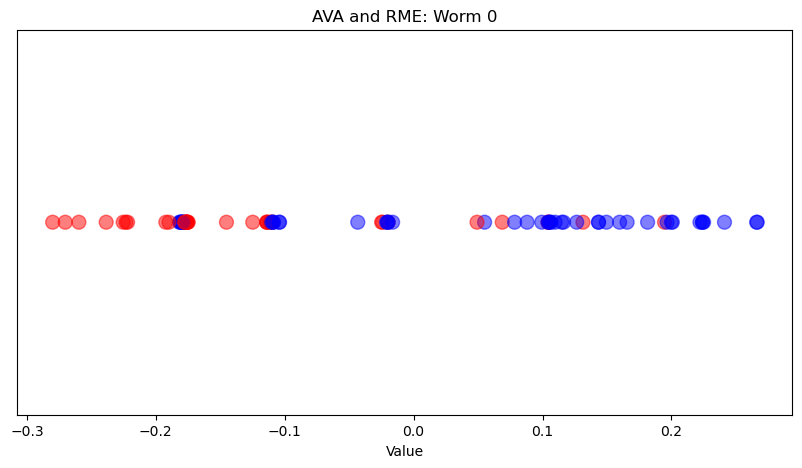

In [32]:
axis_trans_df.columns = ['Value', 'Category']

# Create a color map manually
color_map = {
    'RME': 'blue',  # Color for 'RME'
    'AVA': 'red'  # Color for 'AVA'
}

# Map labels to colors using the color map
label_colors = axis_trans_df['Category'].map(color_map)

# Create scatter plot with specified figure size
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(axis_trans_df['Value'], [0] * len(axis_trans_df), c=label_colors, s=100, alpha = 0.5)
ax.set_xlabel('Value')
ax.yaxis.set_visible(False)
ax.set_title('AVA and RME: Worm 0')
# plt.savefig('/Users/iuliarusu/Documents/Sharpee/final_images/figure3/ava_rme_axis_0.svg', format='svg', bbox_inches='tight')
plt.show()


In [33]:
axis_trans_df

,Value,Category
0,-0.109862,AVA
1,-0.11369,AVA
2,-0.114053,AVA
3,-0.109785,AVA
4,-0.111404,AVA
...,...,...
77,0.078332,RME
78,0.165586,RME
79,0.224936,RME
80,0.266511,RME


In [44]:
axis_trans_dfs = []

#bulk code
worms = [
w0_ava_rme,
w1_ava_rme,
w2_ava_rme,
w3_ava_rme,
w4_ava_rme,
w5_ava_rme,
w6_ava_rme
]

worm_labels = [
ava_rme_0_labels,
ava_rme_1_labels,
ava_rme_2_labels,
ava_rme_3_labels,
ava_rme_4_labels,
ava_rme_5_labels,
ava_rme_6_labels
]

for worm, worm_label in zip(worms, worm_labels):  # Iterate over both worms and their labels simultaneously
    # Convert worm data to a DataFrame
    df_data = pd.DataFrame(worm)

    # Reference point for tangent space (origin)
    reference_point_tangent_space = np.zeros(df_data.shape[1])

    # Transform coordinates from native to Poincare ball
    hyp_poincare = hyp_to_hyp_poincare(df_data)

    # Constant for hyperbolic space
    c_hyperbolicSpace = 1

    # Calculate tangent vectors using the logarithmic map
    hyp_tangent = hyp_poincare.copy()
    for i in range(hyp_poincare.shape[0]):
        current_position_hyp = np.squeeze(hyp_tangent.values[i])
        hyp_tangent.iloc[i] = logarithmic_map(reference_point_tangent_space, current_position_hyp, c_hyperbolicSpace)

    # Add identity labels to the tangent data
    hyp_tangent['identity'] = worm_label

    # Compute mean for RME and AVA groups
    RME_means = hyp_tangent[hyp_tangent['identity'] == 'RME'].iloc[:, 0:3].mean(axis=0).to_numpy()
    AVA_means = hyp_tangent[hyp_tangent['identity'] == 'AVA'].iloc[:, 0:3].mean(axis=0).to_numpy()

    # Calculate the normalized difference between RME and AVA means
    diff_means = RME_means - AVA_means
    normalized = diff_means / np.linalg.norm(diff_means)

    # Project data onto the axis of normalized difference
    axis_trans = np.dot(hyp_tangent.iloc[:, 0:3].values, normalized)

    # Create a DataFrame for the transformed axis
    axis_trans_df = pd.DataFrame({'Value': axis_trans, 'Category': worm_label})
    axis_trans_dfs.append(axis_trans_df)

In [35]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'

/var/folders/4x/v6r504vx43l3xd43p7kmbr400000gn/T/ipykernel_40327/3164474713.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


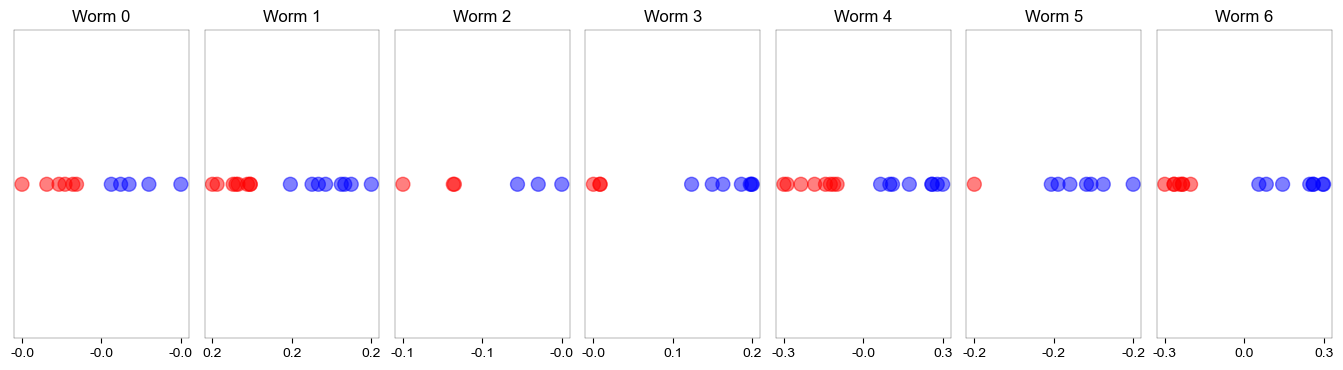

In [45]:
# Define color map for categories
color_map = {
    'RME': 'blue',
    'AVA': 'red'
}

# Create a figure with 7 subplots arranged in a row
fig, axes = plt.subplots(
    1, 7, 
    figsize=(17, 4), 
    sharey=True,
    gridspec_kw={'wspace': 0.09}
)

# Iterate through each transformed dataset and corresponding subplot
for i, (axis_trans_df, ax) in enumerate(zip(axis_trans_dfs, axes)):
    # Map categories to colors
    axis_trans_df.columns = ['Value', 'Category']  # Ensure consistent column names
    label_colors = axis_trans_df['Category'].map(color_map)
    
    # Create scatter plot
    ax.scatter(
        axis_trans_df['Value'], 
        [0] * len(axis_trans_df),  # Plot all points at y=0
        c=label_colors, 
        s=100, 
        alpha=0.5
    )
    ax.set_title(f'Worm {i}')
    ax.set_ylim([-0.001, 0.001])  # Adjust the y-axis range to minimize empty space
    ax.yaxis.set_visible(False)  # Hide the y-axis

    # Set x-axis ticks to 3 evenly spaced values
    x_min, x_max = axis_trans_df['Value'].min(), axis_trans_df['Value'].max()
    xticks = np.linspace(x_min, x_max, 3)  # Define xticks correctly
    ax.set_xticks(xticks)
    ax.set_xticklabels([f'{x:.1f}' for x in xticks])

       # Reduce the width of the box (spines)
    for spine in ax.spines.values():
        spine.set_linewidth(0.2) 

# Adjust layout to avoid overlap
plt.tight_layout()
# plt.savefig('/Users/iuliarusu/Documents/Sharpee/final_images/figure3/ava_rme_axis_all.svg', format='svg', bbox_inches='tight')
# Show the figure
plt.show()

/var/folders/4x/v6r504vx43l3xd43p7kmbr400000gn/T/ipykernel_40327/1894818439.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


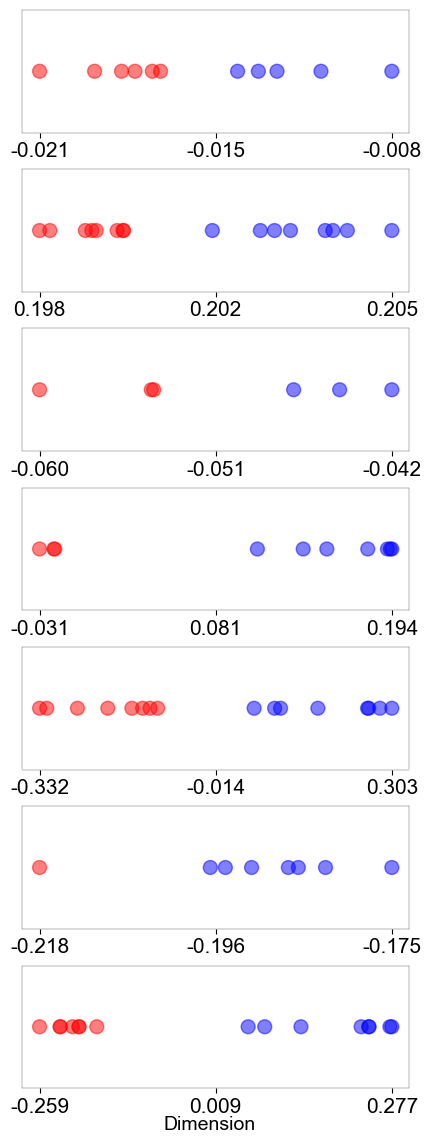

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Define color map for categories
color_map = {
    'RME': 'blue',
    'AVA': 'red'
}

# Create a figure with 7 vertical subplots, each having its own x-axis
fig, axes = plt.subplots(
    7, 1, 
    figsize=(5, 14), 
    sharey=True,  # Keep y-axis consistent but allow separate x-axes
    gridspec_kw={'hspace': 0.3}  # Adjust spacing between plots
)

# Iterate through each transformed dataset and corresponding subplot
for i, (axis_trans_df, ax) in enumerate(zip(axis_trans_dfs, axes)):
    # Ensure correct column names
    axis_trans_df.columns = ['Value', 'Category']  

    # Map categories to colors
    label_colors = axis_trans_df['Category'].map(color_map)
    
    # Create scatter plot for each worm
    ax.scatter(
        axis_trans_df['Value'], 
        [0] * len(axis_trans_df),  # Align points along y=0
        c=label_colors, 
        s=100, 
        alpha=0.5
    )
    
    # Set worm labels on the left side
    # ax.set_ylabel(f'Worm {i}', rotation=0, fontsize=12, labelpad=30, ha='right', va='center')

    # Remove y-axis ticks and labels
    ax.set_yticks([])
    ax.spines['right'].set_visible(True)

    # Set x-axis ticks separately for each subplot
    x_min, x_max = axis_trans_df['Value'].min(), axis_trans_df['Value'].max()
    xticks = np.linspace(x_min, x_max, 3)  # Define xticks for each worm
    ax.set_xticks(xticks)
    ax.set_xticklabels([f'{x:.3f}' for x in xticks], fontsize=15)
    gridspec_kw={'hspace': 0.2} # Reduce the width of the box (spines)
    for spine in ax.spines.values():
        spine.set_linewidth(0.2)

# Set a general x-axis label at the bottom
fig.text(0.5, 0.08, "Dimension", fontsize=14, ha='center')
plt.savefig('/Users/iuliarusu/Documents/Sharpee/final_images/figure3/ava_rme_seperate_graphs.svg', format='svg', bbox_inches='tight')
# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


In [ ]:
axis_trans_df

In [37]:
RME = axis_trans_df[axis_trans_df['Category'] == 'RME']['Value']
AVA = axis_trans_df[axis_trans_df['Category'] == 'AVA']['Value']





In [ ]:
plt.hist([RME, AVA], bins = 20, alpha=0.5, label=['RME', 'AVA'], color = [ 'blue','red'], histtype='stepfilled')


In [ ]:
# Plotting KDE for each category
sns.kdeplot(RME, color='blue', fill=True, alpha=0.5, label='RME')
sns.kdeplot(AVA, color='red', fill=True, alpha=0.5, label='AVA')

# Adding labels and title
plt.xlabel('')
plt.ylabel('Density')
plt.title('Kernel Density Estimate of RME and AVA Values: Stimulus 1')
plt.legend()

# Show the plot
plt.show()

#what should the x-axis be?

In [ ]:
#look at distance between distributions, KS distance 

In [136]:
#use svm in 8 dim space 
#also try a logistic regression, using 8 dim tangent space data and correspoding labels
#try MNE on tangent space coords
y = data.iloc[:, -1]
X = data.iloc[:, 0:5]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [ ]:
logreg = LogisticRegression(random_state=16)

# Train the model
logreg.fit(X_train, y_train)

In [ ]:
logreg.fit(X_train, y_train)

In [140]:
y_pred = logreg.predict(X_test)

In [ ]:
y_pred

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

In [ ]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5,257.44,'Predicted label');

In [ ]:
target_names = ['AVA', 'RME']
print(classification_report(y_test, y_pred, target_names=target_names))